In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import numpy as np
from scipy.stats import norm


In [5]:
data_dir = Path("../data")
csv_files = list(data_dir.glob("*.csv"))
csv_files

[PosixPath('../data/BlackScholes_S100_0000_K100_0000_r0_0500_sigma0_2000_T1_0000_steps252_paths100000.csv')]

Loading file: BlackScholes_S100_0000_K100_0000_r0_0500_sigma0_2000_T1_0000_steps252_paths100000.csv
Extracted parameters: {'S': 100.0, 'K': 100.0, 'r': 0.0, 'sigma': 0.0, 'T': 1.0}
Data shape: (253, 12)


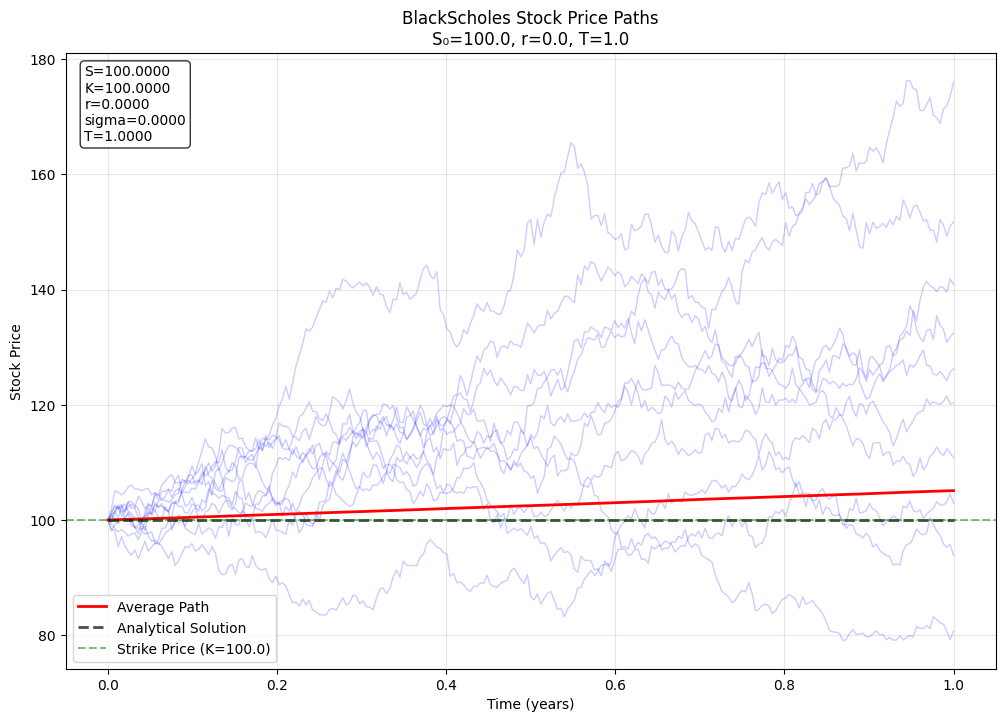


Path Statistics:
Initial price: 100.0000
Final average price: 105.0905
Final analytical price: 100.0000
Price range: [80.6861, 175.9921]
Monte Carlo vs Analytical difference: 5.0905
['BlackScholes', 'S100', '0000', 'K100', '0000', 'r0', '0500', 'sigma0', '2000', 'T1', '0000', 'steps252', 'paths100000']


In [ ]:
# Define correct Black-Scholes analytical solution
def black_scholes_analytical(S, K, T, r, sigma, t):
    """Calculate Black-Scholes analytical solution for stock price evolution.
    This gives the expected value of the stock price at time t."""
    # Expected value of geometric Brownian motion
    return S * np.exp(r * t)  # This is the expected value under risk-neutral measure

latest_file = max(csv_files, key=lambda x: x.stat().st_mtime)
print(f"Loading file: {latest_file.name}")

# Extract parameters from filename
params = latest_file.stem.split('_')
model_name = params[0]

# Extract all parameters including sigma - now handling decimal points directly
params_dict = {}
for p in params[1:]:
    if p.startswith('S'):
        params_dict['S'] = float(p[1:])  # Just convert directly
    elif p.startswith('K'):
        params_dict['K'] = float(p[1:])
    elif p.startswith('r'):
        params_dict['r'] = float(p[1:])
    elif p.startswith('T'):
        params_dict['T'] = float(p[1:])
    elif p.startswith('sigma'):
        params_dict['sigma'] = float(p[5:])  # Remove 'sigma' prefix and convert

print("Extracted parameters:", params_dict)

# Read the CSV file
df = pd.read_csv(latest_file)
print(f"Data shape: {df.shape}")

# Calculate analytical solution
times = df['time'].values
analytical_prices = black_scholes_analytical(
    params_dict['S'],
    params_dict['K'],
    params_dict['T'],
    params_dict['r'],
    params_dict['sigma'],
    times
)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot individual paths with low opacity
path_columns = [col for col in df.columns if col.startswith('path_')]
for col in path_columns:
    plt.plot(df['time'], df[col], 'b-', alpha=0.2, linewidth=1)

# Plot average path with higher opacity and thickness
plt.plot(df['time'], df['average_path'], 'r-',
            linewidth=2, label='Average Path')

# Add analytical solution
plt.plot(times, analytical_prices, 'k--',
         linewidth=2, label='Analytical Solution', alpha=0.7)


# Add horizontal line at strike price if available
if 'K' in params_dict:
    plt.axhline(y=params_dict['K'], color='g', linestyle='--',
                alpha=0.5, label=f"Strike Price (K={params_dict['K']})")

# Customize the plot
plt.title(f"{model_name} Stock Price Paths\n" +
            f"S₀={params_dict['S']}, r={params_dict['r']}, T={params_dict['T']}")
plt.xlabel("Time (years)")
plt.ylabel("Stock Price")
plt.grid(True, alpha=0.3)
plt.legend()

# Add text box with parameters
param_text = "\n".join([
    f"{k}={v:.4f}" for k, v in params_dict.items()
])
plt.text(0.02, 0.98, param_text,
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Print some statistics
print("\nPath Statistics:")
print(f"Initial price: {df.iloc[0]['average_path']:.4f}")
print(f"Final average price: {df.iloc[-1]['average_path']:.4f}")
print(f"Final analytical price: {analytical_prices[-1]:.4f}")
print(f"Price range: [{df.iloc[-1][path_columns].min():.4f}, {df.iloc[-1][path_columns].max():.4f}]")
print(f"Monte Carlo vs Analytical difference: {abs(df.iloc[-1]['average_path'] - analytical_prices[-1]):.4f}")

print(params)